# Document Redaction with Azure AI Document Intelligence layout analysis and Azure OpenAI GPT-4o

This sample demonstrates how to use Azure AI Document Intelligence and Azure OpenAI GPT models to redact any required texts from a document. 

![Data Redaction](../../../images/redaction-document-intelligence-openai.png)

This is achieved by the following process:

- Analyze a document using Azure AI Document Intelligence's `prebuilt-layout` model to perform advanced OCR analysis, extracting per-page text and words (including bounding boxes).
- For each page:
  - Construct a system prompt that defines the instruction for locating words to redact.
  - Construct a user prompt that includes specific details for what to redact, and the page analysis result.
  - Use the Azure OpenAI chat completions API with the GPT-4o model to generate a structured output from the content that details the words to redact from the document page.
  - Redact over each word to remove from the document page using the bounding boxes provided by the analysis result.
- Save the redacted document to an output file.

## Use Cases

- Pre-procesing of documents for compliance with data privacy regulations ahead of downstream processing.
- Need for customized redaction rules based on your specific requirements using natural language instructions.

## Objectives

By the end of this sample, you will have learned how to:

- Perform OCR analysis on a document using Azure AI Document Intelligence.
- Use prompt engineering techniques to instruct GPT-4o to locate specific words to redact from the OCR analysis result.
- Use the [Structured Outputs feature](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/structured-outputs?tabs=python-secure) to generate a consistent response from Azure OpenAI's GPT-4o model.
- Redact words from a document using the results from the GPT-4o model.
- Save the redacted document to an output file.

## Useful Tips

- Combine this technique with a [page classification](../classification/README.md) approach to reduce the number of pages to redact to only those that match your criteria for redaction.
- You can also combine this technique with a post-processing [document data extraction](../extraction/README.md) approach to extract specific information from the document after redaction.

## Setup

### Import modules

This sample takes advantage of the following Python dependencies:

- **azure-ai-documentintelligence** to interface with the Azure AI Document Intelligence API for analyzing documents.
- **openai** to interface with the Azure OpenAI chat completions API to generate structured outputs using the GPT-4o model.
- **azure-identity** to securely authenticate with deployed Azure Services using Microsoft Entra ID credentials.
- **pdf2image** for converting a PDF file into a set of images per page.
- **Pillow** for manipulating the page images to redact words.

The following local components are also used:

- [**redaction**](../modules/samples/models/redaction.py) to provide the expected structured output JSON schema for redactions in a document.
- [**openai_confidence**](../modules/samples/confidence/openai_confidence.py) to calculate the confidence of the redaction process based on the `logprobs` response from the OpenAI API request.
- [**document_processing_result**](../modules/samples/models/document_processing_result.py) to store the results of the redaction process as a file.
- [**stopwatch**](../modules/samples/utils/stopwatch.py) to measure the end-to-end execution time for the redaction process.
- [**app_settings**](../modules/samples/app_settings.py) to access environment variables from the `.env` file.

In [ ]:
import sys
sys.path.append('../modules/') # Import local modules

from IPython.display import display
import os
import pandas as pd
from dotenv import dotenv_values
import json
from openai import AzureOpenAI
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import AnalyzeResult, DocumentContentFormat
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from pdf2image import convert_from_bytes
from PIL import ImageDraw

from samples.app_settings import AppSettings
from samples.utils.stopwatch import Stopwatch
from samples.utils.storage_utils import create_json_file
from samples.models.document_processing_result import DataRedactionResult

from samples.models.redaction import Redaction
from samples.utils.custom_json_encoder import CustomJsonEncoder
from samples.confidence.confidence_utils import merge_confidence_values
from samples.confidence.openai_confidence import evaluate_confidence as evaluate_openai_confidence
from samples.confidence.document_intelligence_confidence import evaluate_confidence as evaluate_di_confidence

### Configure the Azure services

To use Azure AI Document Intelligence and Azure OpenAI, their SDKs are used to create client instances using a deployed endpoint and authentication credentials.

For this sample, the credentials of the Azure CLI are used to authenticate with the deployed services.

In [2]:
# Set the working directory to the root of the repo
working_dir = os.path.abspath('../../../')
settings = AppSettings(dotenv_values(f"{working_dir}/.env"))
sample_path = f"{working_dir}/samples/python/redaction"
sample_name = "document-redaction-gpt"

# Configure the default credential for accessing Azure services using Azure CLI credentials
credential = DefaultAzureCredential(
    exclude_workload_identity_credential=True,
    exclude_developer_cli_credential=True,
    exclude_environment_credential=True,
    exclude_managed_identity_credential=True,
    exclude_powershell_credential=True,
    exclude_shared_token_cache_credential=True,
    exclude_interactive_browser_credential=True
)

openai_token_provider = get_bearer_token_provider(credential, 'https://cognitiveservices.azure.com/.default')

openai_client = AzureOpenAI(
    azure_endpoint=settings.openai_endpoint,
    azure_ad_token_provider=openai_token_provider,
    api_version="2024-12-01-preview" # Requires the latest API version for structured outputs.
)

document_intelligence_client = DocumentIntelligenceClient(
    endpoint=settings.ai_services_endpoint,
    credential=credential
)

### Load the PDF file

To prepare the document for processing, we must first load it. This sample uses a sample [Invoice](../../assets/invoices/invoice_1.pdf) document to redact from.

> **Note**: More invoice examples can be found in the [assets folder](../../assets/invoices/). This sample is not limited to invoice, and you're encouraged to explore your own documents.

In [3]:
# Define the path to the metadata file
path = f"{working_dir}/samples/assets/invoices/"
metadata_fname = "invoice_1.json"  # Change this to the file you want to evaluate
metadata_fpath = f"{path}{metadata_fname}"

# Load the metadata from the JSON file
with open(metadata_fpath, "r") as f:
    data = json.load(f)

# Extract the PDF file name and path from the metadata
pdf_fname = data['fname']
pdf_fpath = f"{path}{pdf_fname}"

# Read the PDF file content
with open(pdf_fpath, "rb") as f:
    pdf_content = f.read()

## Analyze the PDF with Azure AI Document Intelligence

The following code block uses the `DocumentIntelligenceClient` to perform OCR and layout analysis on the PDF using Azure AI Document Intelligence's `prebuilt-layout` model. The analysis result contains the necessary per-page breakdown of content and bounding boxes.

> **Note**: You can find more information about the `AnalyzeResult` class in our [documentation](https://learn.microsoft.com/en-us/python/api/azure-ai-documentintelligence/azure.ai.documentintelligence.models.analyzeresult?view=azure-python).

In [4]:
# Perform OCR and layout analysis on the PDF using DocumentIntelligenceClient
with Stopwatch() as di_stopwatch:
    poller = document_intelligence_client.begin_analyze_document(
        model_id="prebuilt-layout",
        body=pdf_content,
        output_content_format=DocumentContentFormat.MARKDOWN,
        content_type="application/pdf"
    )
    
    result: AnalyzeResult = poller.result()

# Extract pages from the analysis result
pages = result.pages

## Determine Redactions using Azure OpenAI

For each page in the analyzed PDF, we construct a request to Azure OpenAI's GPT-4o model to determine the words to redact. The request is structured as follows:

- **System Prompt**: This prompt instructs the model to locate the words to redact based on the bounding boxes provided by the OCR analysis.
- **User Prompt**: This prompt includes specific details for what to redact, and the page analysis result. This can be completely customized to your specific needs, including redacting non-sensitive information.

The response from the GPT-4o model provides a [Structured Output](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/structured-outputs?tabs=python-secure) that details the words to redact from the specific page.

In [5]:
system_prompt = f"""You are an AI assistant that determines words to be redacted from documents based on an OCR analysis result.
                        
## On your ability to locate words to redact

- The OCR analysis provided includes all of the necessary information to determine the words to redact.
- **Do not make up information that is not present in the OCR analysis.**
"""

In [6]:
user_text_prompt = """Redact all of the following information from this page:
                        
- Person Names (full, first, or last names)
- Personal Identification Numbers (including social security numbers, driver's license numbers, passport numbers, etc.)
- Phone Numbers (including area codes)
- Postal Addresses (including postal codes)
- Email Addresses

Do not redact any other information."""

In [7]:
page_redactions = [] 
page_redactions_choices = []

# Iterate through each page in the analyzed PDF
with Stopwatch() as redactions_stopwatch: 
    for page in result.pages: 
        page_content = { "page_number": page.page_number, "content": result.content[page.spans[0]['offset']: page.spans[0]['offset'] + page.spans[0]['length']], "words": page.words }
        
        # Prepare the user content for the OpenAI API including any specific details for processing this type of document, and the document page content.
        user_content = []
        
        user_content.append({
            "type": "text",
            "text": user_text_prompt
        })
        
        user_content.append({
            "type": "text",
            "text": json.dumps(page_content, cls=CustomJsonEncoder)
        })
                
        completion = openai_client.beta.chat.completions.parse(
            model=settings.gpt4o_model_deployment_name,
            messages=[
                {
                    "role": "system",
                    "content": system_prompt
                },
                {
                    "role": "user",
                    "content": user_content
                }
            ],
            response_format=Redaction,
            temperature=0.1,
            top_p=0.1,
            logprobs=True # Enabled to determine the confidence of the response.
        )
        
        page_redaction = completion.choices[0].message.parsed
        
        page_redactions_choices.append(completion.choices[0])
        page_redactions.append(page_redaction)

## Redact page words from the document

Once the words to redact are determined, we can proceed to redact them from the document. This is achieved by overlaying a redacted box over the words to remove using the bounding boxes determined by GPT-4o. The redacted document is then saved to an output file.

> **Note**: The polygon bounding box values from Azure AI Document Intelligence's analysis result are first normalized to the size of the page. This ensures that the redacted boxes are correctly positioned on the page image.

In [8]:
def normalize_polygon(polygon: list[float], page):
    """
    A helper function to normalize the polygon coordinates to the page dimensions.
    
    The polygon will consist of 8 floating point values, in the format [TopLeftX, TopLeftY, TopRightX, TopRightY, BottomRightX, BottomRightY, BottomLeftX, BottomLeftY]
    """
    
    width = page.width
    height = page.height
    
    normalized_polygon = []
    
    for i in range(0, len(polygon), 2):
        x = polygon[i]
        y = polygon[i + 1]
        
        normalized_polygon.append(x / width)
        normalized_polygon.append(y / height)
        
    return normalized_polygon    

In [9]:
with Stopwatch() as docredact_stopwatch:
    # Build dictionaries for fast lookup by page_number
    redaction_dict = {r.page_number: r for r in page_redactions}
    pages_dict = {p.page_number: p for p in pages}

    # Convert PDF to images
    page_images = convert_from_bytes(pdf_content)

    # Loop through each page image and apply redactions
    redact_page_images = []

    for page_idx, page_image in enumerate(page_images):
        page_redaction = next((r for r in page_redactions if r.page_number == (page_idx + 1)), None)
        page_result = next((p for p in pages if p.page_number == (page_idx + 1)), None)
        
        if page_redaction is not None and page_redaction.words is not None:
            for word in page_redaction.words:
                normalized_polygon = normalize_polygon(word.polygon, page_result)
                
                # Calculate bounding box positions
                tl_x, tl_y = normalized_polygon[0], normalized_polygon[1]
                br_x, br_y = normalized_polygon[4], normalized_polygon[5]
                
                page_image_width = page_image.width
                page_image_height = page_image.height
                
                draw = ImageDraw.Draw(page_image)
                
                bbox = [tl_x * page_image_width, tl_y * page_image_height, br_x * page_image_width, br_y * page_image_height]
                draw.rectangle(bbox, fill="black")
                
        redact_page_images.append(page_image)

## Visualize the outputs

To provide context for the execution of the code, the following code blocks visualize the outputs of the redaction process.

This includes:

- The contents of the redacted document.
- The confidence score of the determined words to redact based on combining the confidence scores of the Azure AI Document Intelligence layout analysis and the log probability of the output generated by Azure OpenAI's GPT-4o model.
- The execution time of the end-to-end process.

In [10]:
page_confidences = []

for idx, page_redaction in enumerate(page_redactions):
    page_redaction_choice = page_redactions_choices[idx]
    page_redaction_dict = page_redaction.model_dump()
    
    di_confidence = evaluate_di_confidence(page_redaction_dict, result)
    oai_confidence = evaluate_openai_confidence(page_redaction_dict, page_redaction_choice)

    page_confidence = merge_confidence_values(di_confidence, oai_confidence)
    page_confidences.append(page_confidence)

confidence = {
    "_overall": sum([p["_overall"] for p in page_confidences]) / len(page_confidences),
    "pages": page_confidences
}

In [11]:
# Gets the total execution time of the data redaction process.
total_elapsed = docredact_stopwatch.elapsed + redactions_stopwatch.elapsed + di_stopwatch.elapsed

In [12]:
# Save the output of the data redaction result.
redaction_result = DataRedactionResult(
    redacted=page_redactions,
    confidence=confidence,
    execution_time=total_elapsed
)

create_json_file(f"{sample_path}/{sample_name}.{pdf_fname}.json", redaction_result)

In [13]:
df = pd.DataFrame([
    {
        "Execution Time": f"{total_elapsed:.2f} seconds",
        "Document Intelligence Execution Time": f"{di_stopwatch.elapsed:.2f} seconds",
        "OpenAI Execution Time": f"{redactions_stopwatch.elapsed:.2f} seconds",
        "Doc Redaction Time": f"{docredact_stopwatch.elapsed:.2f} seconds",
        "Confidence": f"{confidence['_overall'] * 100:.2f}%",
    }
])

display(df)

,Execution Time,Document Intelligence Execution Time,OpenAI Execution Time,Doc Redaction Time,Confidence
0,66.53 seconds,5.35 seconds,60.93 seconds,0.25 seconds,98.09%


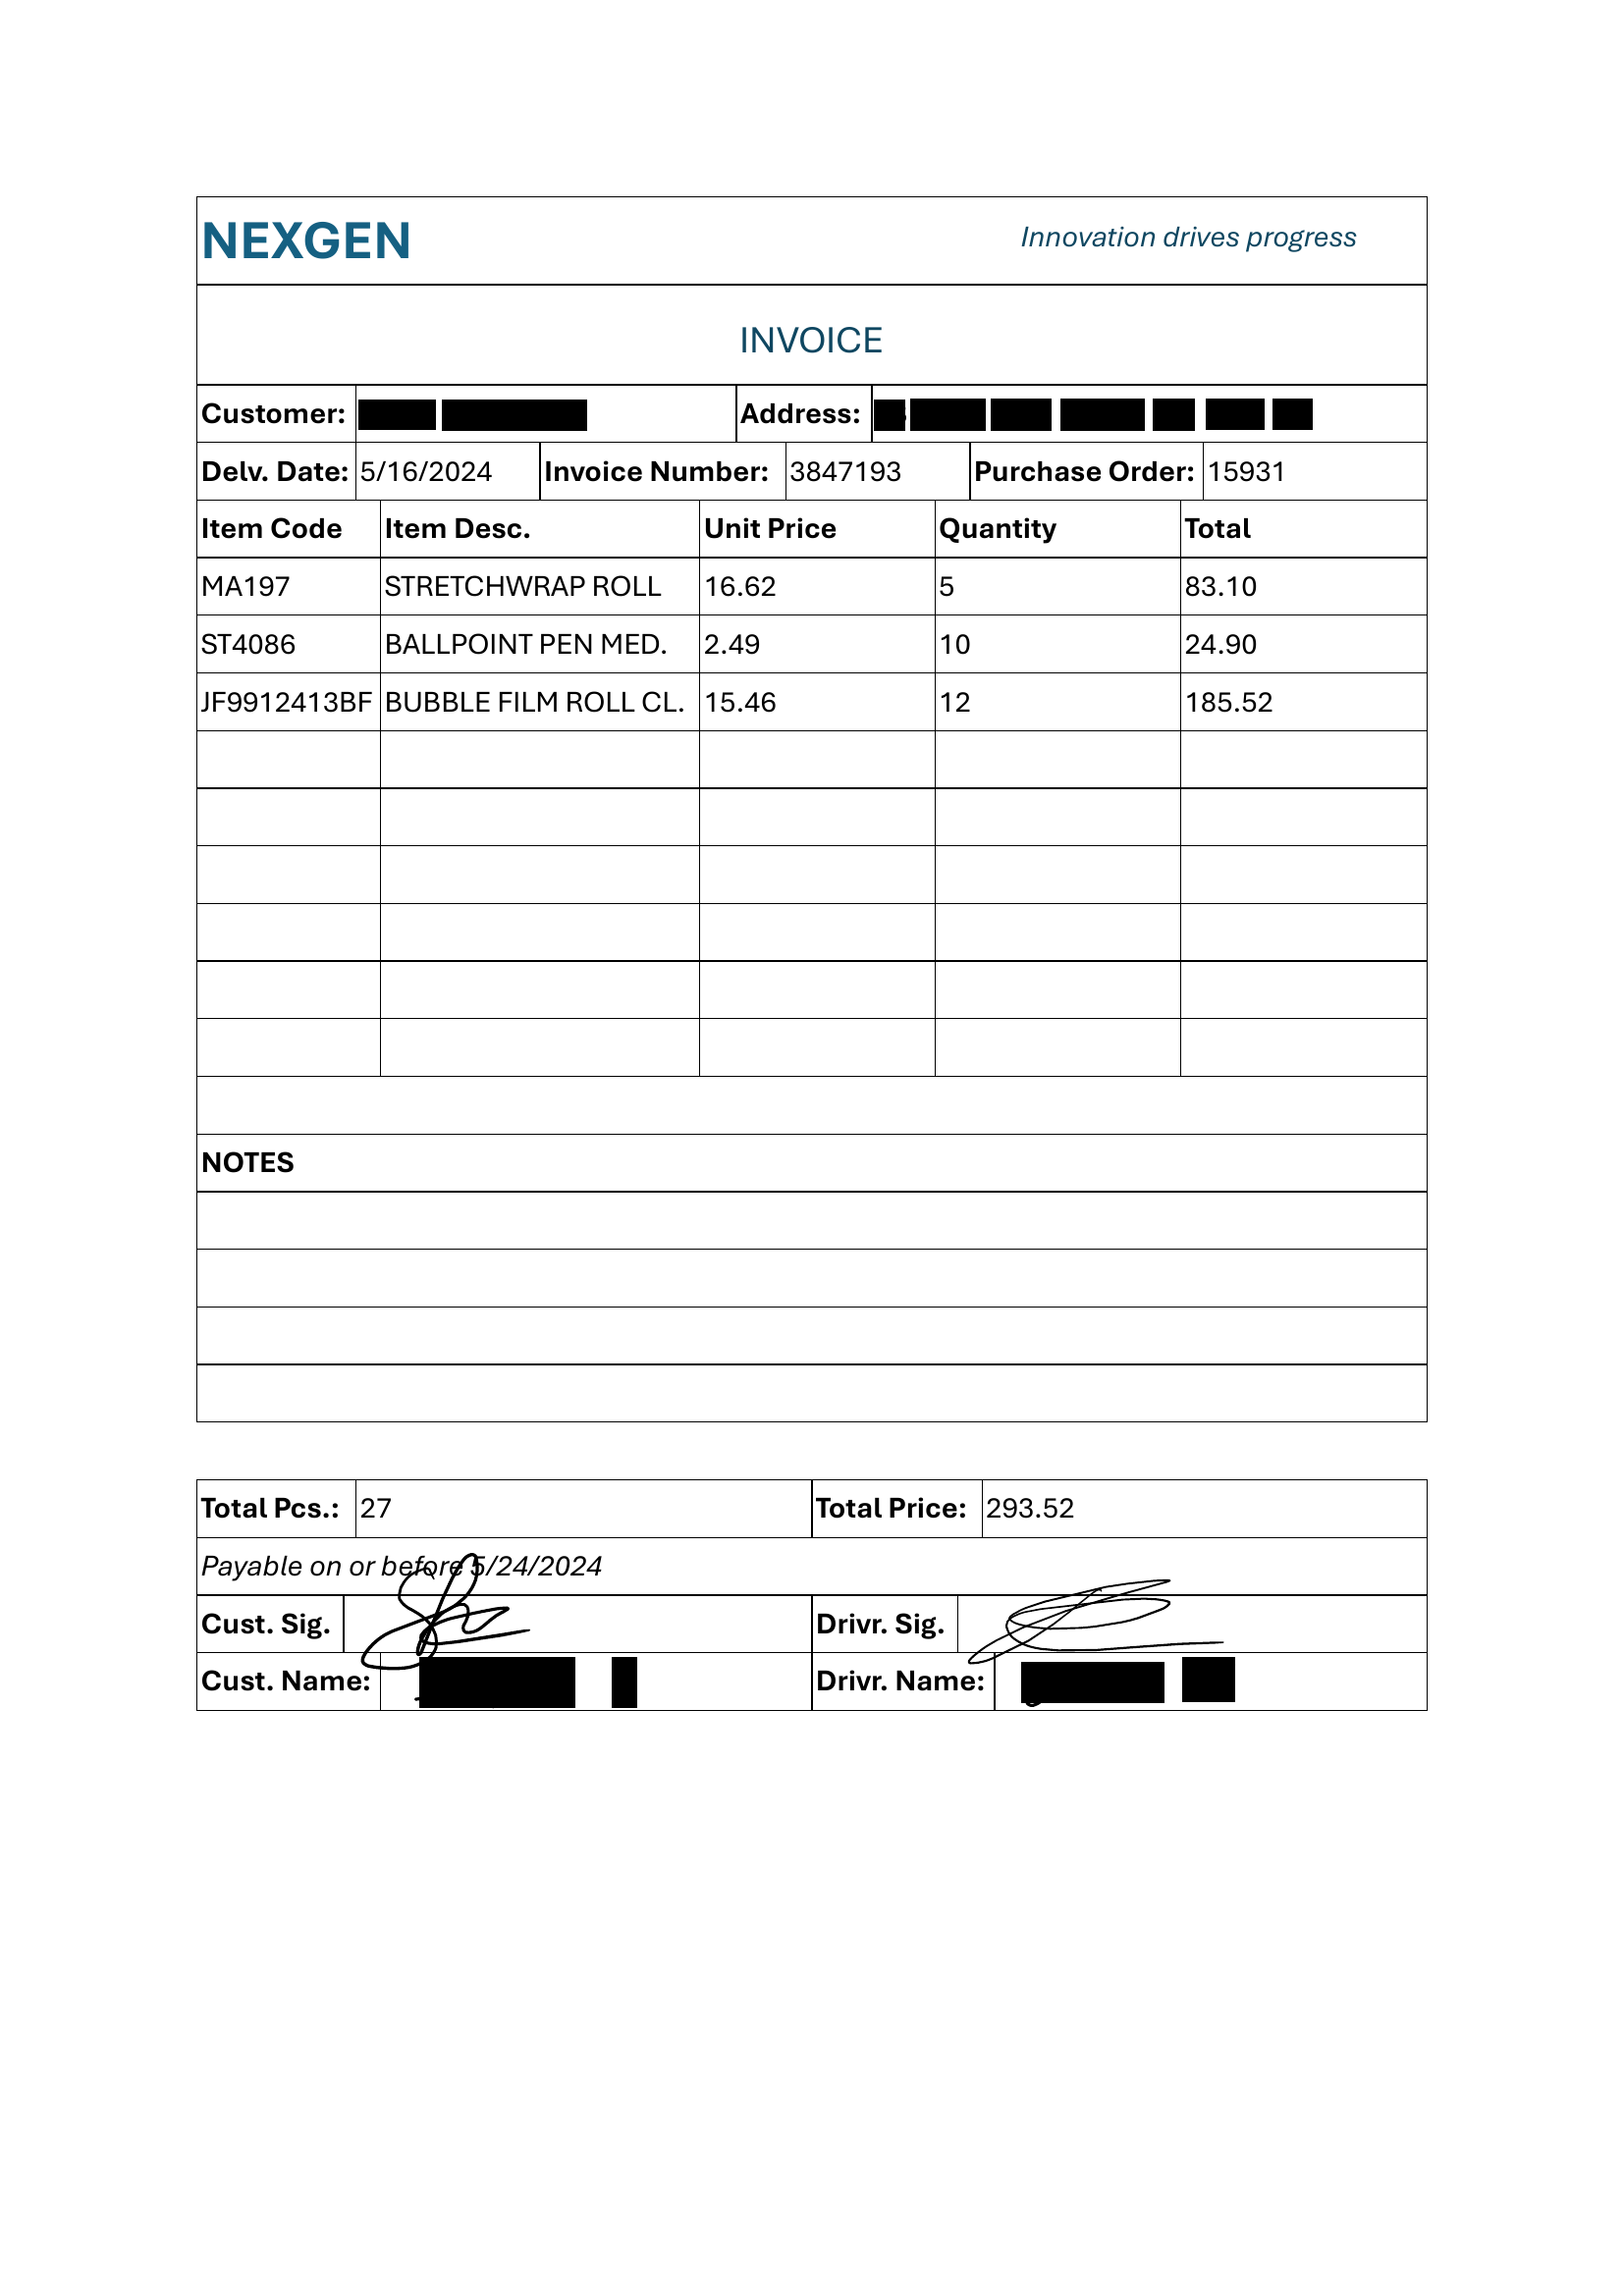

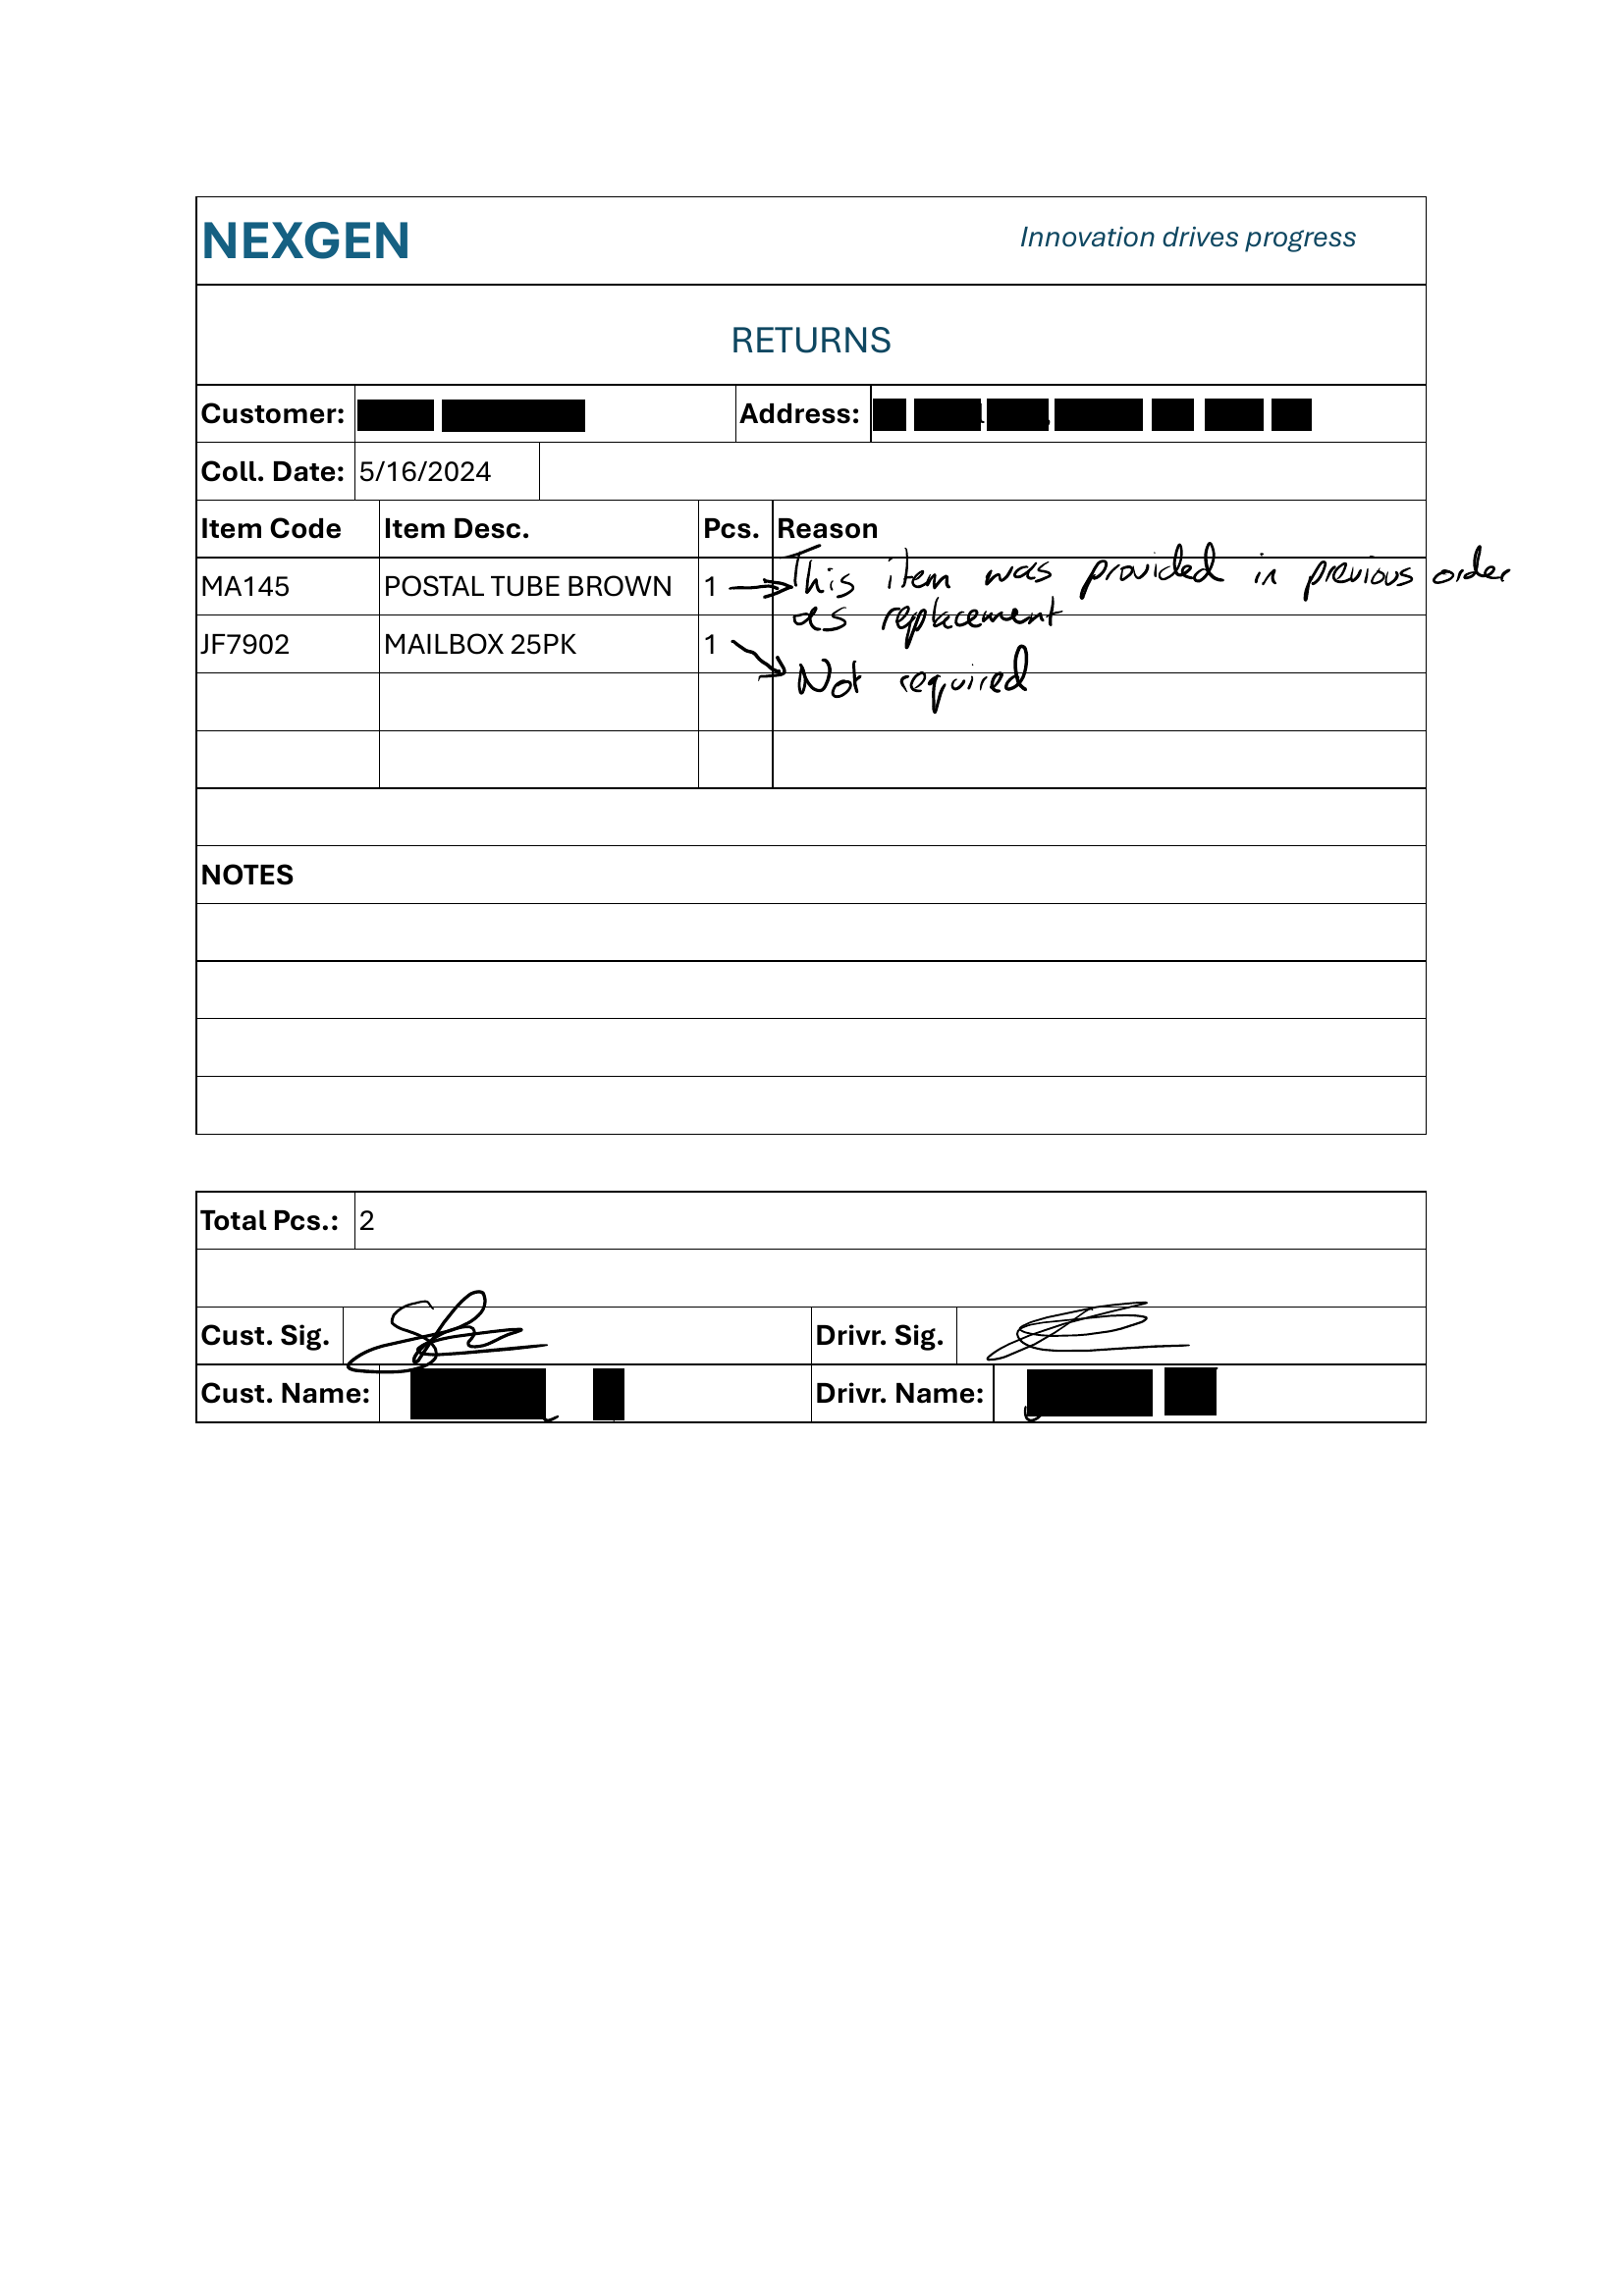

In [14]:
# Save the redacted images as a new PDF
redacted_pdf_fpath = f"{sample_path}/{sample_name}_redacted_{pdf_fname}"
redact_page_images[0].save(redacted_pdf_fpath, save_all=True, append_images=redact_page_images[1:])

# Display the redacted images
for page_image in redact_page_images:
    display(page_image)